In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
tf.enable_eager_execution()
print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./mnist/data', one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data\t10k-images-idx3-ubyte.gz
Extracting ./mnist/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [9]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                  activation=tf.nn.relu, input_shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))  #여긴 default가 softmax므로 없어도 됨
    return model

In [10]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [14]:
# ( , , , 32) 320 나오는 이유: 32개 X 10 (필터의 값인 W가 9개 + bias값!)
# bias가 있는 이유: 전부 0에 가까워 0 되는 걸 방지하기 위해 1(에 가까운) b값 있음 (tensorflow)

In [15]:
optimizer = tf.train.AdamOptimizer(0.001)  # 가중치를 자동으로 수정하는 optimizer 객체 생성

In [16]:
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
print('total_batch', total_batch)

total_batch 550


In [19]:
for step in range(10):
    total_cost = 0
    total_accuracy = 0
    
    # tf mnist 모델의 next_batch함수 이용해, 지정한 100개 크기만큼 이미지 -> X, 결과 -> Y 대입
    for i in range(total_batch):
        X, Y = mnist.train.next_batch(batch_size)
        X = X.reshape(-1, 28, 28, 1)
        
        with tf.GradientTape() as tape:
            
            #X에 저장된 이미지 정보를 입력으로 CNN 모델 실행, 분류 결과 hypothesis에 저장
            hypothesis = model(X, training=True)  #train이므로 true. 나중에 test 떄는 false
            
            # 로지스틱 회귀식의 오차 계산식 -> cost에 대입, tf에서 자동으로 오차 가장 적게하는 가중치
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=
                                                                            hypothesis,
                                                                            labels=Y))
            grads = tape.gradient(cost, model.variables)  # 가중치 값들을 리턴
            
        optimizer.apply_gradients(zip(grads, model.variables)) # 오차 최소화 되도록 가중치 수정
        total_cost += cost
        correct_prediction = tf. equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        total_accuracy += accuracy
        
    print('step: {} Loss: {:.4f} accuracy: {:.4f}'.format(step, total_cost/total_batch,
                                                          total_accuracy/total_batch))

step: 0 Loss: 1.5721 accuracy: 0.8949
step: 1 Loss: 1.5034 accuracy: 0.9589
step: 2 Loss: 1.4938 accuracy: 0.9684
step: 3 Loss: 1.4887 accuracy: 0.9731
step: 4 Loss: 1.4867 accuracy: 0.9748
step: 5 Loss: 1.4841 accuracy: 0.9775
step: 6 Loss: 1.4827 accuracy: 0.9789
step: 7 Loss: 1.4812 accuracy: 0.9802
step: 8 Loss: 1.4806 accuracy: 0.9807
step: 9 Loss: 1.4802 accuracy: 0.9811


In [22]:
test_images = mnist.test.images
test_images = test_images.reshape(-1, 28, 28, 1)
test_labels = mnist.test.labels

predict = model(test_images, training=False)

print(predict)
# 이미지 각각에서 0~9에 해당하는 확률 저장되어 있음(0번째 col에는 이미지가 0일 확률, 1번째 col에도...)

print('='*40)
predict = tf.argmax(predict, 1)


print('='*40)
print(test_labels) # one hot encoding으로 저장되어 있음 (000000100 등)

test_labels = tf.argmax(test_labels, 1) # 최대값 1이 저장된 col의 index를 test_label에 대입

print('='*40)
print(test_labels)

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.03743934e-34 2.36393986e-28 1.00000000e+00 ... 0.00000000e+00
  3.12046143e-31 0.00000000e+00]
 [1.42186640e-23 1.00000000e+00 2.18034813e-21 ... 7.74200840e-23
  1.70684099e-24 3.03850695e-30]
 ...
 [0.00000000e+00 8.02462691e-31 1.95457920e-35 ... 9.36569813e-28
  2.50336694e-23 2.00378897e-26]
 [6.68378471e-31 3.14246131e-26 0.00000000e+00 ... 1.01445564e-35
  5.80568823e-16 1.77818647e-26]
 [1.95772127e-27 2.40703414e-37 4.79076837e-33 ... 0.00000000e+00
  5.92621162e-29 0.00000000e+00]], shape=(10000, 10), dtype=float32)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
tf.Tensor([7 2 1 ... 4 5 6], shape=(10000,), dtype=int64)


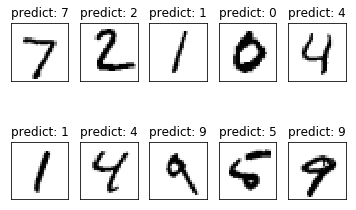

In [23]:
fig = plt.figure()
for i in range(10):
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('predict: %d' %predict[i])
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   cmap=plt.cm.gray_r)
plt.show()